# 🔬 PrexSyn Interactive Chemical Space Exploration

This Jupyter Notebook provides an interactive interface to explore chemical space using PrexSyn. You can run each cell individually to see the results and modify parameters as needed.

In [ ]:
# Import basic libraries
import pathlib
import torch
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

# Import PrexSyn components
from prexsyn.applications.analog import generate_analogs
from prexsyn.factories import load_model
from prexsyn.utils.draw import draw_synthesis
from prexsyn.samplers.basic import BasicSampler
from prexsyn_engine.synthesis import Synthesis
from prexsyn_engine.fingerprints import tanimoto_similarity

# Set up RDKit drawing in notebook
IPythonConsole.ipython_useSVG = True

print('✅ Environment initialized! PrexSyn is ready to use.')

In [2]:
# Load the model (this may take a moment)
model_path = pathlib.Path('./data/trained_models/v1_converted.yaml')
if model_path.exists():
    facade, model = load_model(model_path, train=False)
    model = model.to('cpu')  # Use CPU since no GPU detected
    print('✅ Model loaded successfully!')
else:
    print('❌ Model file not found. Please ensure you have the trained models.')

✅ Model loaded successfully!


In [ ]:
def generate_and_display_analogs(smiles, num_results=5, num_samples=32):
    """
    Generate analogs of a molecule and display them.
    
    Args:
        smiles: Input SMILES string
        num_results: Number of top results to show
        num_samples: Number of samples to generate
    """
    try:
        # Convert SMILES to molecule
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f'❌ Invalid SMILES: {smiles}')
            return
        
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        
        # Create sampler
        sampler = BasicSampler(
            model,
            token_def=facade.tokenization.token_def,
            num_samples=num_samples,
            max_length=16,
        )
        
        # Generate analogs
        result = generate_analogs(
            facade=facade,
            model=model,
            sampler=sampler,
            fp_property=facade.property_set['ecfp4'],
            mol=mol,
        )
        
        # Process results — skip multi-fragment (mixture) products
        visited = set()
        result_list = []
        for synthesis in result['synthesis']:
            if synthesis.stack_size() != 1:
                continue
            for prod in synthesis.top().to_list():
                prod_smi = Chem.MolToSmiles(prod, canonical=True)
                if '.' in prod_smi:   # skip disconnected/mixture molecules
                    continue
                if prod_smi in visited:
                    continue
                visited.add(prod_smi)
                sim = tanimoto_similarity(prod, mol, fp_type='ecfp4')
                result_list.append((prod, synthesis, sim))
        
        # Sort by similarity
        result_list.sort(key=lambda x: x[2], reverse=True)
        
        # Display input molecule
        print(f'Input Molecule: {canonical_smi}')
        input_mol = Chem.MolFromSmiles(canonical_smi)
        AllChem.Compute2DCoords(input_mol)
        display(input_mol)
        
        # Display analogs
        print(f'\nTop {num_results} Analogs:')
        for i, (prod, synthesis, sim) in enumerate(result_list[:num_results]):
            smi = Chem.MolToSmiles(prod, canonical=True)
            print(f'\n### Result {i+1} (Similarity: {sim:.3f})')
            AllChem.Compute2DCoords(prod)
            display(prod)
            print(f'SMILES: {smi}')
            
    except Exception as e:
        print(f'❌ Error generating analogs: {e}')

## 2. Interactive Molecule Exploration

Now let's explore some specific molecules. You can modify the SMILES strings below to try different molecules!

🔬 Exploring analogs of Aspirin...
Input Molecule: CC(=O)Oc1ccccc1C(=O)O


[2026-02-21 23:28:36.128] [prexsyn_engine] [info] Loading building blocks from cache: data/chemical_spaces/enamine_rxn115/primary_building_blocks
[2026-02-21 23:28:41.939] [prexsyn_engine] [info] BuildingBlockList: 223243 building blocks loaded from cache
[2026-02-21 23:29:18.301] [prexsyn_engine] [info] ReactionList: Loading reactions from cache data/chemical_spaces/enamine_rxn115/reactions
[2026-02-21 23:29:18.316] [prexsyn_engine] [info] ReactionList: Loaded 115 reactions


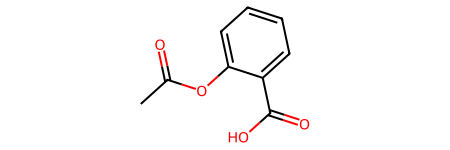


Top 3 Analogs:

### Result 1 (Similarity: 1.000)


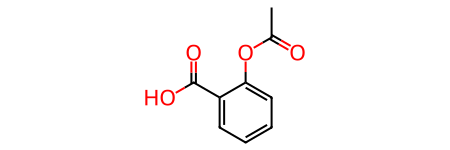

SMILES: CC(=O)Oc1ccccc1C(=O)O

### Result 2 (Similarity: 0.622)


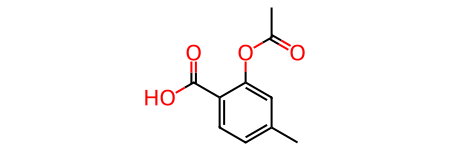

SMILES: CC(=O)Oc1cc(C)ccc1C(=O)O

### Result 3 (Similarity: 0.538)


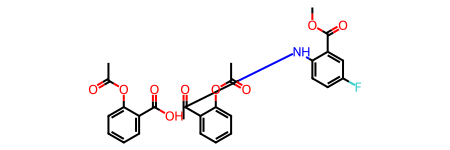

SMILES: CC(=O)Oc1ccccc1C(=O)O.COC(=O)c1cc(F)ccc1NC(=O)c1ccccc1OC(C)=O


In [4]:
# Example 1: Aspirin
print('🔬 Exploring analogs of Aspirin...')
generate_and_display_analogs('CC(=O)OC1=CC=CC=C1C(=O)O', num_results=3)

🔬 Exploring your molecule: OC[C@@H]1[C@H](CO[C@@H]1c1cc(OC)c(c(c1)OC)OC)C(=O)c1cc(OC)c(c(c1)OC)OC
Input Molecule: COc1cc(C(=O)[C@H]2CO[C@H](c3cc(OC)c(OC)c(OC)c3)[C@@H]2CO)cc(OC)c1OC


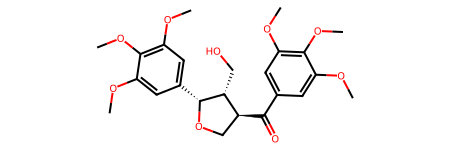


Top 3 Analogs:

### Result 1 (Similarity: 0.574)


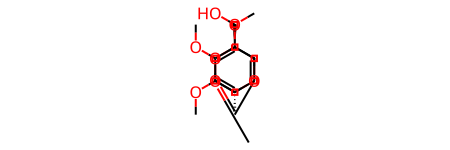

SMILES: COc1cc(C(=O)[C@@H]2CO[C@@H](CO)CO2)cc(OC)c1OC

### Result 2 (Similarity: 0.574)


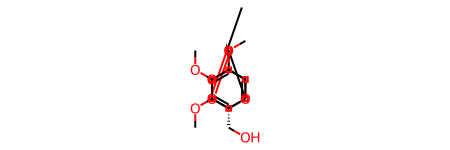

SMILES: COc1cc(C(=O)[C@H]2CO[C@H](CO)CO2)cc(OC)c1OC

### Result 3 (Similarity: 0.524)


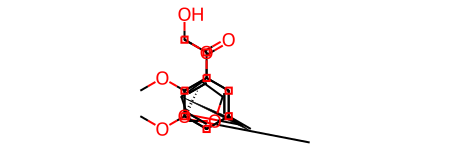

SMILES: COc1cc(C(=O)[C@@H]2COC[C@H]2c2cccc(C(=O)CO)c2)cc(OC)c1OC


In [6]:
# 🎯 YOUR TURN: Try your own molecule!
# Replace the SMILES string below with any molecule you're interested in
# Some examples to try:
# - "C1=CC=C(C=C1)C(=O)O" (Benzoic acid)
# - "C1=CC=NC=C1" (Pyrimidine)
# - "C1CCCCC1" (Cyclohexane)
# - "C1=CC=CC=C1" (Benzene)

your_molecule = 'OC[C@@H]1[C@H](CO[C@@H]1c1cc(OC)c(c(c1)OC)OC)C(=O)c1cc(OC)c(c(c1)OC)OC'  # 🔧 Change this to your molecule!
print(f'🔬 Exploring your molecule: {your_molecule}')
generate_and_display_analogs(your_molecule, num_results=3)